# Contest 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

### Читаем данные

In [2]:
train_x = pd.read_csv('SongsPrediction/train_x.csv')
train_y = pd.read_csv('SongsPrediction/train_y.csv')
test_x = pd.read_csv('SongsPrediction/test_x.csv')

### Сохраняем индекс теста на будущее и дропаем индексы

In [3]:
test_id = test_x['id']
test_x = test_x.drop('id', axis=1)
train_x = train_x.drop('Unnamed: 0', axis=1)
train_y = train_y.drop('Unnamed: 0', axis=1)

### В итоге учил на cpu потому что выбрал маленькие батчи

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
device

'cpu'

### Видим слишком большой хвост

<Axes: >

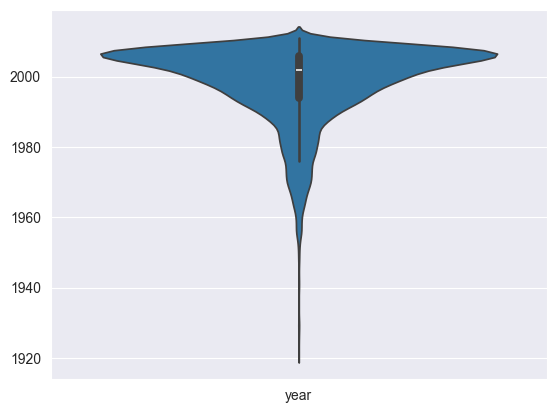

In [5]:
sns.violinplot(train_y)

### Всякие преобразования и дроп хвоста никак не помог, поэтому в итоге все оставлено как есть

In [6]:
target_mean = train_y.mean()
target_std = train_y.std()
train_y = (train_y - target_mean) / target_std

### А вот нормализация таргета существенно увеличивает скорость сходимости к решению. То чего можно было добиться за 150 итераций после преобразования достигается за 20.

### Нормализуем входные данные, сплитуем и делаем даталоадеры

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_x)
X_test_scaled = scaler.transform(test_x)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(train_y.values, dtype=torch.float32).view(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=222)
### Мои тесты показали что в данном случае резульаты на маленьких батчах лучше
batch_size = 4
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

### Создаем архитектуру нейросети

### Простота в данном случае залог успеха, более сложные модели или модели с всякими нормализациями были только хуже

In [8]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(90, 16),
            nn.ELU(), # или ReLU, разница невилика
            
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)


### Функция обучения, со сбором данных для построения графика

In [20]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50):
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)
        if scheduler is not None:
            scheduler.step(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: '
              f'{scheduler.get_last_lr() if scheduler is not None else optimizer.lr}')
    
    return train_loss_history, val_loss_history

### Создаем модель, оптимизатор и планировщик

In [10]:
model = Network().to(device)
# пробовал разные лоссы, но в итоге остановился просто на MSE
criterion = torch.nn.MSELoss()
# пробовал Adam и AdamW, но вроде как Adam оказался лучше
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [11]:
target_std ** 2
# т.к. таргет был нормализован, шкала mse сместилась.
# чтобы примерно понять какой лосс в исходных единицах измерения, надо умножить лосс на это число

year    122.060239
dtype: float64

### Обучение модели

Epoch [1/25], Loss: 0.9314, Val Loss: 0.8143, LR: [0.0001]
Epoch [2/25], Loss: 0.8171, Val Loss: 0.7617, LR: [0.0001]
Epoch [3/25], Loss: 0.7756, Val Loss: 0.7393, LR: [0.0001]
Epoch [4/25], Loss: 0.7538, Val Loss: 0.7241, LR: [0.0001]
Epoch [5/25], Loss: 0.7409, Val Loss: 0.7213, LR: [0.0001]
Epoch [6/25], Loss: 0.7337, Val Loss: 0.7144, LR: [0.0001]
Epoch [7/25], Loss: 0.7270, Val Loss: 0.7143, LR: [0.0001]
Epoch [8/25], Loss: 0.7223, Val Loss: 0.7082, LR: [0.0001]
Epoch [9/25], Loss: 0.7183, Val Loss: 0.7079, LR: [0.0001]
Epoch [10/25], Loss: 0.7150, Val Loss: 0.7065, LR: [0.0001]
Epoch [11/25], Loss: 0.7116, Val Loss: 0.7052, LR: [0.0001]
Epoch [12/25], Loss: 0.7084, Val Loss: 0.7029, LR: [0.0001]
Epoch [13/25], Loss: 0.7057, Val Loss: 0.7012, LR: [0.0001]
Epoch [14/25], Loss: 0.7035, Val Loss: 0.6993, LR: [0.0001]
Epoch [15/25], Loss: 0.7012, Val Loss: 0.6994, LR: [0.0001]
Epoch [16/25], Loss: 0.6987, Val Loss: 0.6985, LR: [0.0001]
Epoch [17/25], Loss: 0.6966, Val Loss: 0.6972, LR

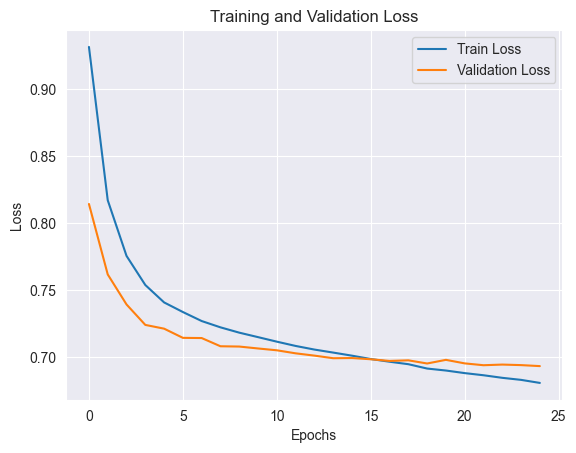

In [12]:
num_epochs = 25
train_loss_history, val_loss_history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs)


plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Что предсказывает модель для всех имеющихся размеченных данных?

In [13]:
train_x_new = pd.read_csv('SongsPrediction/train_x.csv')
train_y_new = pd.read_csv('SongsPrediction/train_y.csv')
train_x_new = train_x_new.drop('Unnamed: 0', axis=1)
train_y_new = train_y_new.drop('Unnamed: 0', axis=1)
train_x_new = torch.tensor(scaler.transform(train_x_new), dtype=torch.float32)


with torch.no_grad():
    X_val_pred = model(train_x_new.to(device)).detach().cpu().numpy().ravel()
    # обратное преобразование для таргета
    X_val_pred = np.round(X_val_pred * target_std.to_numpy() + target_mean.to_numpy())

    
example = pd.DataFrame({'Predicted': X_val_pred, 'True': train_y_new.to_numpy().ravel()})
example['Delta'] = example['Predicted'] - example['True']
example

,Predicted,True,Delta
0,1994.0,2001,-7.0
1,2002.0,2006,-4.0
2,1993.0,1989,4.0
3,2001.0,1997,4.0
4,2003.0,2001,2.0
...,...,...,...
13995,1998.0,1999,-1.0
13996,1995.0,2008,-13.0
13997,1993.0,1999,-6.0
13998,2000.0,1993,7.0


### График остатков модели

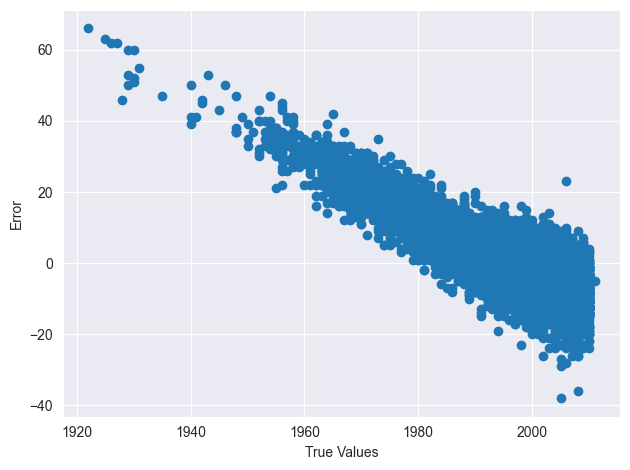

In [14]:
plt.scatter(example['True'], example['Delta'])
plt.xlabel('True Values')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

### Видна основная проблема - т.к. ранних семплов очень мало, а ошибка у нас MSE (хотя с другими не лучше) модель "заваливается" сильно вверх для старых семлов и вниз для новых. Это печально, но адеватного решения придумать не удалось

### Получаем итоговые предикты

In [15]:
with torch.no_grad():
    inputs = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
    # outputs = model(inputs).detach().cpu().numpy().round()
    outputs = (model(inputs).detach().cpu().numpy() * target_std.to_numpy() + target_mean.to_numpy()).round()
outputs

array([[1998.],
       [2007.],
       [1996.],
       ...,
       [1990.],
       [1989.],
       [1992.]])

### Объединяем с сохраненным индексом

In [16]:
pred = pd.concat((test_id, pd.Series(outputs.ravel())), axis=1)
pred

,id,0
0,3416,1998.0
1,18991,2007.0
2,11105,1996.0
3,18902,2003.0
4,18958,1999.0
...,...,...
5995,15293,1999.0
5996,7469,1992.0
5997,6586,1990.0
5998,17875,1989.0


### Сохраняем веса модели и предсказаний

In [175]:
torch.save(model.state_dict(), "SongsPrediction/contest1_2.pth")
pred.to_csv('SongsPrediction/contest1_22_int.csv', index=False)

# Обучение на рукописном оптимизаторе

### Немного подправим уже написанный оптимизатор чтобы он работал с торчевской нейронкой: (комментариями отмечено что именно)

In [17]:
class Adam:
# теперь принимаем параметры в момент инициализации, а не при вызове step
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        # делаем из генератора список для простоты и вызываем retain_grad чтобы все было хорошо
        self.params = list(params)
        for i in self.params:
            i.retain_grad()
        self.m = {}
        self.s = {}
# теперь не принимает на вход параметры и градиенты
    def step(self):
        if not self.m:
            self.m = [torch.zeros_like(p) for p in self.params]
            self.s = [torch.zeros_like(p) for p in self.params]
# добавляем no_grad
        with torch.no_grad():
            for i, param in enumerate(self.params):
                # получаем параметр и высчитанный градиент
                p = param
                g = param.grad.data
                m = self.m[i]
                s = self.s[i]
    
                m = self.beta1 * m + (1 - self.beta1) * g
                s = self.beta2 * s + (1 - self.beta2) * (g ** 2)
    
                p -= self.lr * m / (torch.sqrt(s) + self.eps)
    
                self.m[i] = m
                self.s[i] = s
# написали свой zero_grad
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()

In [26]:
model = Network().to(device)
criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)
scheduler = None

Epoch [1/25], Loss: 0.8600, Val Loss: 0.7757, LR: 0.0001
Epoch [2/25], Loss: 0.7904, Val Loss: 0.7505, LR: 0.0001
Epoch [3/25], Loss: 0.7667, Val Loss: 0.7381, LR: 0.0001
Epoch [4/25], Loss: 0.7542, Val Loss: 0.7284, LR: 0.0001
Epoch [5/25], Loss: 0.7449, Val Loss: 0.7216, LR: 0.0001
Epoch [6/25], Loss: 0.7381, Val Loss: 0.7220, LR: 0.0001
Epoch [7/25], Loss: 0.7331, Val Loss: 0.7204, LR: 0.0001
Epoch [8/25], Loss: 0.7291, Val Loss: 0.7166, LR: 0.0001
Epoch [9/25], Loss: 0.7245, Val Loss: 0.7154, LR: 0.0001
Epoch [10/25], Loss: 0.7216, Val Loss: 0.7155, LR: 0.0001
Epoch [11/25], Loss: 0.7190, Val Loss: 0.7116, LR: 0.0001
Epoch [12/25], Loss: 0.7156, Val Loss: 0.7122, LR: 0.0001
Epoch [13/25], Loss: 0.7133, Val Loss: 0.7106, LR: 0.0001
Epoch [14/25], Loss: 0.7100, Val Loss: 0.7114, LR: 0.0001
Epoch [15/25], Loss: 0.7074, Val Loss: 0.7085, LR: 0.0001
Epoch [16/25], Loss: 0.7058, Val Loss: 0.7091, LR: 0.0001
Epoch [17/25], Loss: 0.7032, Val Loss: 0.7100, LR: 0.0001
Epoch [18/25], Loss: 0.

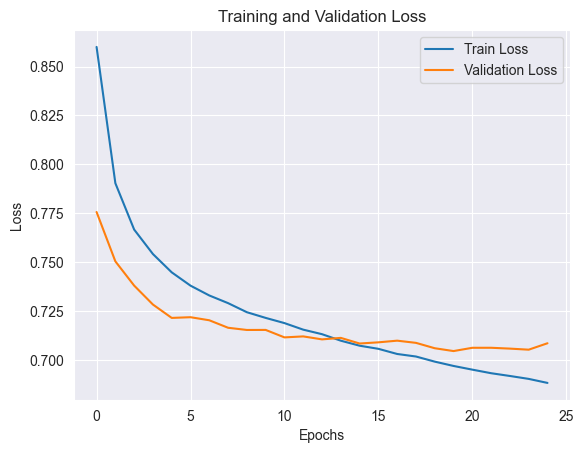

In [27]:
num_epochs = 25
train_loss_history, val_loss_history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs)


plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Как бы это не было удивительно, но все реально работает не хуже чем на встроенном оптимизаторе

### Нарисуем график остатков и убедимся что все +- так же

In [28]:
train_x_new = pd.read_csv('SongsPrediction/train_x.csv')
train_y_new = pd.read_csv('SongsPrediction/train_y.csv')
train_x_new = train_x_new.drop('Unnamed: 0', axis=1)
train_y_new = train_y_new.drop('Unnamed: 0', axis=1)
train_x_new = torch.tensor(scaler.transform(train_x_new), dtype=torch.float32)


with torch.no_grad():
    X_val_pred = model(train_x_new.to(device)).detach().cpu().numpy().ravel()
    X_val_pred = np.round(X_val_pred * target_std.to_numpy() + target_mean.to_numpy())
    # X_val_pred = np.round(X_val_pred)

    
example = pd.DataFrame({'Predicted': X_val_pred, 'True': train_y_new.to_numpy().ravel()})
example['Delta'] = example['Predicted'] - example['True']
example

,Predicted,True,Delta
0,1995.0,2001,-6.0
1,2002.0,2006,-4.0
2,1995.0,1989,6.0
3,2002.0,1997,5.0
4,2003.0,2001,2.0
...,...,...,...
13995,2002.0,1999,3.0
13996,1997.0,2008,-11.0
13997,1996.0,1999,-3.0
13998,2000.0,1993,7.0


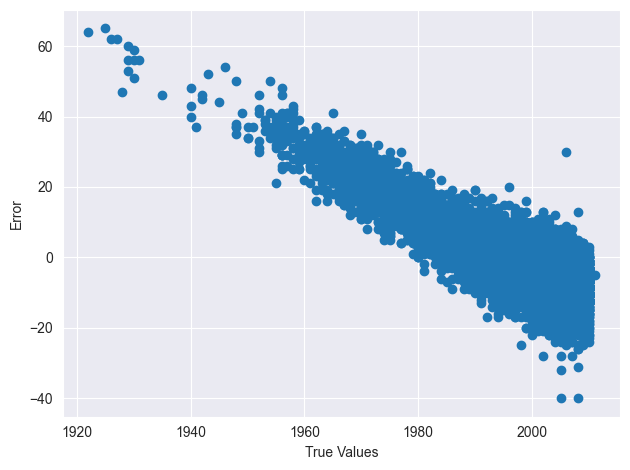

In [29]:
plt.scatter(example['True'], example['Delta'])
plt.xlabel('True Values')
plt.ylabel('Error')
plt.tight_layout()
plt.show()